# Machine Learning Project(Classification)

## Excalibur
Team Leader:  Jith Philip Xavier(202418022) <br>
Team Members: Dhruv Jain(202418020),
                Naman Gandhi(202418038),
                Anujit Nair(202418036)

## Loading Data & Preprocessing

In [98]:
# Importing the necesssary libraries.

import pandas as pd
import json
import spacy
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,roc_curve,auc

In [99]:
# Here,we will be defining the input and output file names.
# Data Source - https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/review_categories

input_file = 'Baby_Products.jsonl'  
output_file = 'baby_products.csv'  

# Here,we are reading the JSON file and have to store each line as a JSON object in a list.
data = []
with open(input_file, 'r', encoding = 'utf-8') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
df.to_csv(output_file, index = False)
print(f"Conversion is Successful!")

Conversion is Successful!


In [100]:
df.shape

(6028884, 10)

In [101]:
# Defining a function to categorize rating into three classes.

def process_rating(x):
  if x >= 4:
    return "positive"
  if x == 3:
    return "neutral"
  else:
    return "negative"

In [102]:
# We are sampling the data as it is too large!
# And the sampling is done based on our model objective which is prediction of customer sentiments.
# We are using stratified sampling to ensure that the data is representative of the population.
# We took random sample of 40000 instances from each of the three categories of rating.

df['rating_num'] = df['rating'].apply(process_rating)

positive_class = df[df['rating_num'] == "positive"]
neutral_class = df[df['rating_num'] == "neutral"]
negative_class = df[df['rating_num'] == "negative"]

sample_positive = positive_class.sample(n=40000, random_state=42)
sample_neutral = neutral_class.sample(n=40000, random_state=42)
sample_negative = negative_class.sample(n=40000, random_state=42)

balanced_sample = pd.concat([sample_positive, sample_neutral, sample_negative])

balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_sample.to_csv('baby_products_rating.csv', index=False)

In [103]:
# This is how our data looks like!

data = pd.read_csv('baby_products_rating.csv')
data.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,rating_num
0,3.0,Mine didn’t work,The product itself is absolutely beautiful and...,[],B078J37T33,B0BJZXNQVX,AFWZCCQVXPGST4A44WFWKQDGBUEA,1614134627391,0,True,neutral
1,3.0,"After 2 years of use, the cons overcame the pros",We have been using this bed for almost 2 years...,[],B001EQ66WK,B0C674RXLM,AGDWW6FZQJQVOH4J3TEIA3SIL45Q,1458619812000,8,True,neutral
2,3.0,Didn't come with level 1 nipples,Disappointed with Thinkbaby starter kit. It di...,[],B003LPUPWO,B003LPUPWO,AFAEL6HCENBCT5UL5KO7LOHKYFFA,1444835023000,0,True,neutral
3,5.0,Five Stars,excellent!,[],B01BTTM8CS,B01BTTM8CS,AH5FKYMIKQYFSH3DVNABGUEEHQ5Q,1478536981000,0,True,positive
4,5.0,Nice,Very well made :),[],B017OPO4QY,B018552J8M,AGGIBFD3U7QSOORJNVXN36I2UFVA,1605498941233,0,True,positive


In [104]:
df = data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             120000 non-null  float64
 1   title              119987 non-null  object 
 2   text               119974 non-null  object 
 3   images             120000 non-null  object 
 4   asin               120000 non-null  object 
 5   parent_asin        120000 non-null  object 
 6   user_id            120000 non-null  object 
 7   timestamp          120000 non-null  int64  
 8   helpful_vote       120000 non-null  int64  
 9   verified_purchase  120000 non-null  bool   
 10  rating_num         120000 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 9.3+ MB


In [105]:
# Dropping the missing values in our data.

df = df.dropna(subset = ['text', 'title'])
df = df[df["rating"] != 0]

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119967 entries, 0 to 119999
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   rating             119967 non-null  float64
 1   title              119967 non-null  object 
 2   text               119967 non-null  object 
 3   images             119967 non-null  object 
 4   asin               119967 non-null  object 
 5   parent_asin        119967 non-null  object 
 6   user_id            119967 non-null  object 
 7   timestamp          119967 non-null  int64  
 8   helpful_vote       119967 non-null  int64  
 9   verified_purchase  119967 non-null  bool   
 10  rating_num         119967 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(7)
memory usage: 10.2+ MB


## Exploratory Data Analysis (EDA)

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

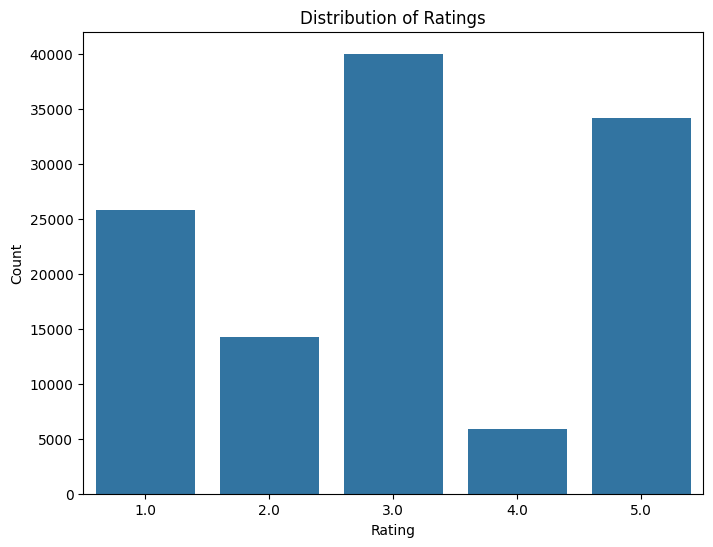

In [108]:
# Bar Chart to show the distribution of Ratings.

rating_counts = df['rating'].value_counts()
plt.figure(figsize = (8, 6))
sns.barplot(x = rating_counts.index, y = rating_counts.values)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

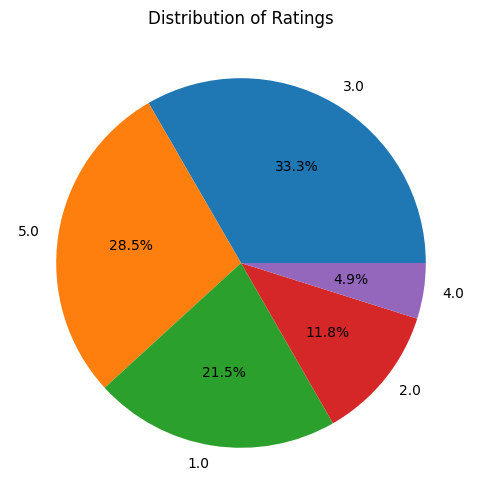

In [109]:
# Pie Chart to show the distribution of Ratings.

rating_counts = rating_counts[rating_counts != 0]
plt.figure(figsize=(8, 6))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Ratings')
plt.show()

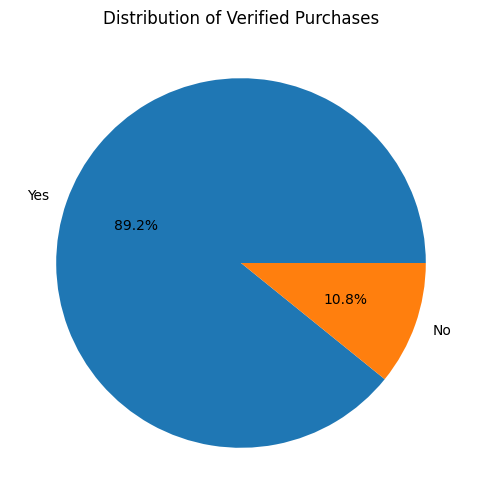

In [110]:
# Pie Chart to show the Distribution of Verified Purchases.

vp_counts = df['verified_purchase'].value_counts()
labels = {True : "Yes",False : "No"}
plt.figure(figsize=(8, 6))
plt.pie(vp_counts, labels=[labels[x] for x in vp_counts.index], autopct='%1.1f%%')
plt.title('Distribution of Verified Purchases')
plt.show()

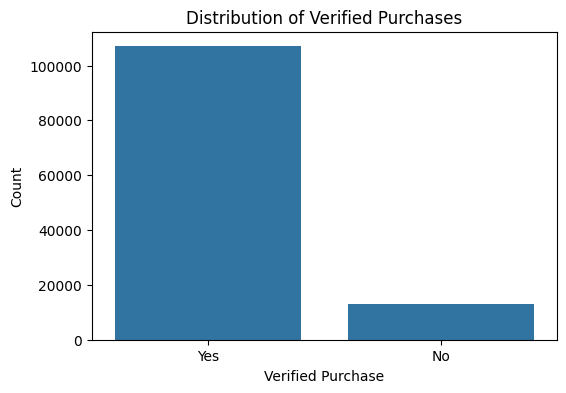

In [111]:
# Bar Chart to show the Distribution of Verified Purchases.

vp_counts = df['verified_purchase'].value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=[labels[x] for x in vp_counts.index], y=vp_counts.values)
plt.title('Distribution of Verified Purchases')
plt.xlabel('Verified Purchase')
plt.ylabel('Count')
plt.show()

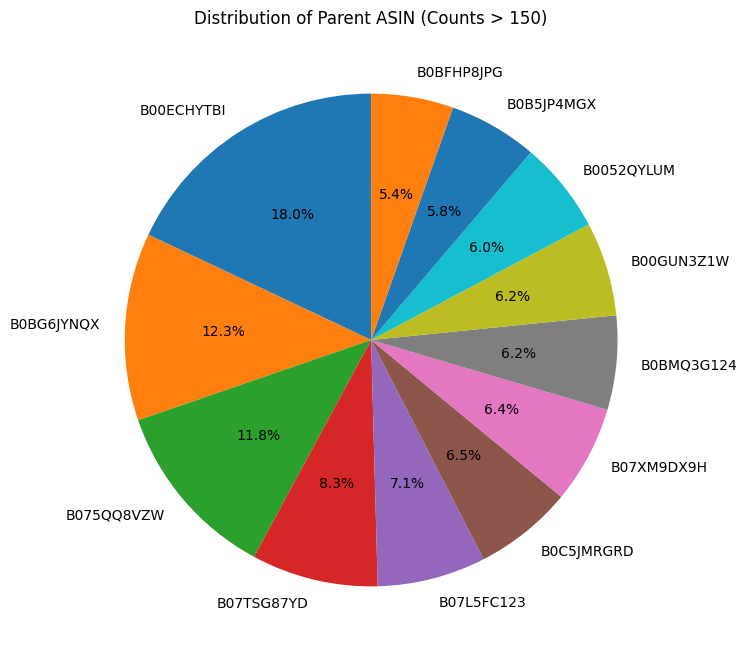

In [112]:
# Pie Chart to show the distribution of Parent ASIN.

# An item can come in a variety of sizes and colors. 
# Each color and size combination is called a variation or child ASIN. 
# The abstraction of the variations is called the Parent ASIN. 

parent_asin_counts = df['parent_asin'].value_counts()

filtered_counts = parent_asin_counts[parent_asin_counts > 150]

plt.figure(figsize=(8, 8))
plt.pie(filtered_counts, labels=filtered_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Parent ASIN (Counts > 150)')
plt.show()

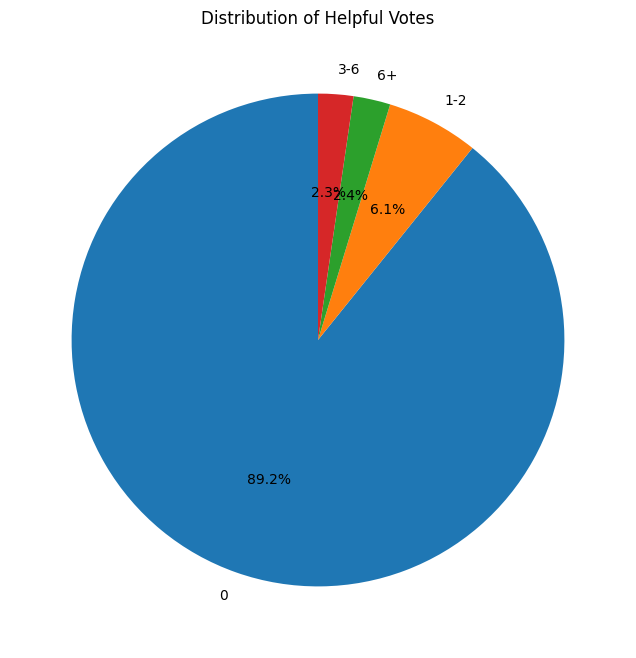

In [113]:
# Pie Chart to show the distribution of Helpful Votes.

bins = [0, 1, 3, 6, float('inf')]
labels = ['0', '1-2', '3-6', '6+']

df['helpful_vote_group'] = pd.cut(df['helpful_vote'], bins=bins, labels=labels, include_lowest=True)

helpful_vote_counts = df['helpful_vote_group'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(helpful_vote_counts, labels=helpful_vote_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Helpful Votes')
plt.show()

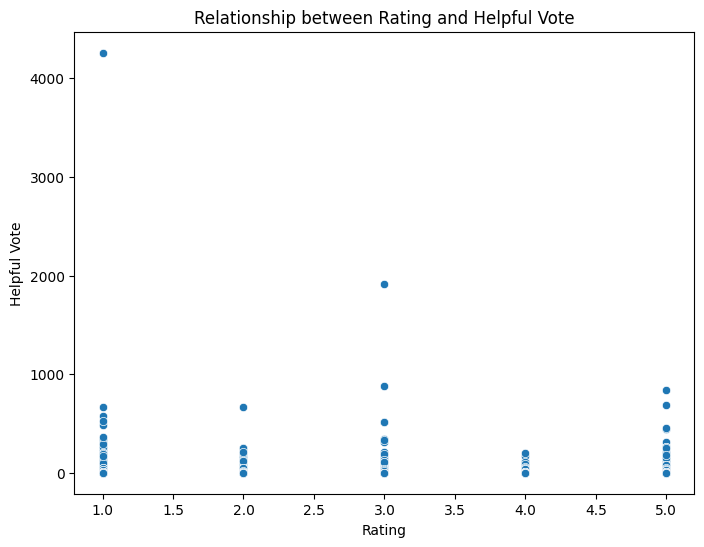

In [114]:
# Scatter Plot to show the relationship between Rating and Helpful Votes.

plt.figure(figsize=(8, 6))
sns.scatterplot(x='rating', y='helpful_vote', data=df)
plt.title('Relationship between Rating and Helpful Vote')
plt.xlabel('Rating')
plt.ylabel('Helpful Vote')
plt.show()

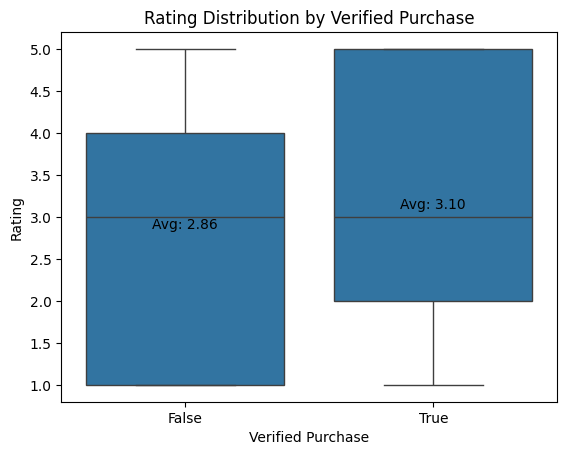

In [115]:
# Below Boxplot is used to depict Rating Distribution by Verified Purchases.

average_ratings = df.groupby('verified_purchase')['rating'].mean()

sns.boxplot(x='verified_purchase', y='rating', data=df)

for i, avg_rating in enumerate(average_ratings):
    plt.text(i, avg_rating, f'Avg: {avg_rating:.2f}', ha='center')

plt.xlabel('Verified Purchase')
plt.ylabel('Rating')
plt.title('Rating Distribution by Verified Purchase')
plt.show()

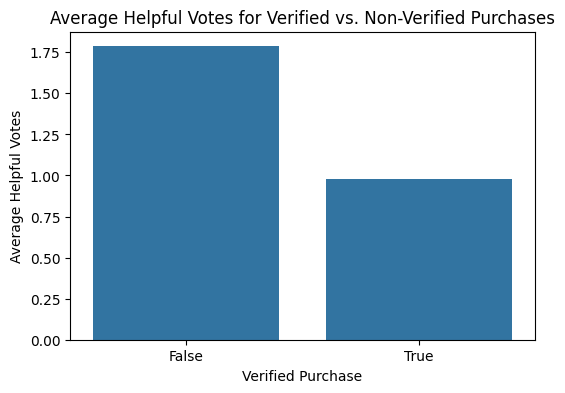

In [116]:
# Bar Chart to show the Average Helpful Votes for Verified vs. Non-Verified Purchases.

verified_helpful_votes = df.groupby('verified_purchase')['helpful_vote'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x='verified_purchase', y='helpful_vote', data=verified_helpful_votes)
plt.title('Average Helpful Votes for Verified vs. Non-Verified Purchases')
plt.xlabel('Verified Purchase')
plt.ylabel('Average Helpful Votes')
plt.show()


## Model Building

In [117]:
# Creating a new feature by combining the title and text attributes.
# This combined feature will be used for the prediction.

df['title_text'] = df['title'] + " " + df["text"]

In [118]:
# Encoding the classes into numerical values.

df["rating"] = df["rating"].apply(process_rating)

def encode_rating(x):
    if x == "negative":
        return 0
    if x == "neutral":
        return 1
    if x == "positive":
        return 2

In [119]:
df["rating"] = df["rating"].apply(encode_rating)

In [120]:
df.rating.value_counts()

rating
1    39994
0    39991
2    39982
Name: count, dtype: int64

In [121]:
# We will use the NLP library spacy to tokenize and lemmatize(group together) the text.

nlp = spacy.load('en_core_web_lg')

def process_text(x):
    doc = nlp(x)
    filtered_tokens = []
    for token in doc:
        if token.is_punct:   
            continue
        filtered_tokens.append(token.lemma_)  
    return " ".join(filtered_tokens)


In [122]:
df['title_text'] = df['title_text'].apply(process_text)

In [123]:
# Data split into train and test sets.(80:10:10)

X_train_val, X_test,y_train_val, y_test = train_test_split(df['title_text'], df['rating'],
                                                    test_size = 0.1, random_state = 2024)

# Next, split the Training + Validation set into separate Training and Validation sets.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=2024)


## Logisitic Regression

### Pseudocode

1. IMPORT necessary libraries for pipeline, logistic regression, evaluation, and plotting.

2. CREATE a pipeline that consists of:
    - TfidfVectorizer() to transform text data into TF-IDF features.
    - LogisticRegression() as the classifier.

3. DEFINE a dictionary of hyperparameters for the TfidfVectorizer and LogisticRegression:
    - For TfidfVectorizer: max_df, min_df, ngram_range, use_idf, smooth_idf, sublinear_tf, norm.
    - For LogisticRegression: regularization parameter C.

4. INITIALIZE RandomizedSearchCV with the pipeline, hyperparameter space, and settings (e.g., cross-validation = 5, scoring = 'accuracy', number of iterations = 15).

5. FIT the RandomizedSearchCV object on the training data (X_train_val, y_train_val).

6. PRINT the best hyperparameters found after tuning.

7. PREDICT class labels on:
    - Training data (y_pred_train).
    - Test data (y_pred_test).

8. PRINT classification report for both training and test data using `classification_report()`.

9. CALCULATE the confusion matrix using `confusion_matrix(y_test, y_pred_test)`.

10. DISPLAY the confusion matrix using `ConfusionMatrixDisplay()` and label the classes (e.g., Negative, Neutral, Positive).

11. GET predicted probabilities for the test set using `predict_proba(X_test)`.

12. FOR each class (0 = Negative, 1 = Neutral, 2 = Positive):
    - CALCULATE fpr, tpr, and thresholds using `roc_curve()`.
    - COMPUTE AUC for each class using `auc()`.

13. PLOT the ROC curve for each class:
    - ADD labels (False Positive Rate, True Positive Rate, ROC curve of each class).
    - DISPLAY the plot with legends.

14. END program.


In [124]:
# Here, we are generating a pipeline for performing Logistic Regression.
pipe = Pipeline([('tfidf', TfidfVectorizer()) ,                                              
                 ('classifier', LogisticRegression())])

param_dist = {
    'tfidf__max_df': np.linspace(0.7, 1.0, 10),      
    'tfidf__min_df': np.arange(1, 10),              
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': [True, False],           
    'tfidf__smooth_idf': [True, False],                    
    'tfidf__sublinear_tf': [True, False], 
    'tfidf__norm': ['l1', 'l2', None],                    
    'classifier__C': np.logspace(-3, 2, 10),                       
}

lr_classifier = RandomizedSearchCV(pipe, param_distributions=param_dist, 
                                   n_iter=15, cv=5, n_jobs=-1, verbose=2, scoring='accuracy', random_state=42)

lr_classifier.fit(X_train_val, y_train_val) 
print("Best hyperparameters: ", lr_classifier.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END classifier__C=0.01291549665014884, tfidf__max_df=0.8333333333333333, tfidf__min_df=4, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=   8.0s
[CV] END classifier__C=0.01291549665014884, tfidf__max_df=0.8333333333333333, tfidf__min_df=4, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=   8.0s
[CV] END classifier__C=0.01291549665014884, tfidf__max_df=0.8333333333333333, tfidf__min_df=4, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=   8.3s
[CV] END classifier__C=0.01291549665014884, tfidf__max_df=0.8333333333333333, tfidf__min_df=4, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=  12.7s
[CV] END classifier

/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV] END classifier__C=0.5994842503189409, tfidf__max_df=0.9666666666666667, tfidf__min_df=8, tfidf__ngram_range=(1, 3), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  29.5s
[CV] END classifier__C=0.5994842503189409, tfidf__max_df=0.9666666666666667, tfidf__min_df=8, tfidf__ngram_range=(1, 3), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  29.7s
[CV] END classifier__C=0.5994842503189409, tfidf__max_df=0.9666666666666667, tfidf__min_df=8, tfidf__ngram_range=(1, 3), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  30.1s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=100.0, tfidf__max_df=0.9, tfidf__min_df=6, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   6.1s
[CV] END classifier__C=0.001, tfidf__max_df=0.7333333333333333, tfidf__min_df=3, tfidf__ngram_range=(1, 3), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True; total time=  35.6s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.001, tfidf__max_df=0.7333333333333333, tfidf__min_df=3, tfidf__ngram_range=(1, 3), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True; total time=  35.5s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=100.0, tfidf__max_df=0.9, tfidf__min_df=6, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   5.9s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=100.0, tfidf__max_df=0.9, tfidf__min_df=6, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   6.0s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=100.0, tfidf__max_df=0.9, tfidf__min_df=6, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   5.9s
[CV] END classifier__C=100.0, tfidf__max_df=0.9, tfidf__min_df=6, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   5.7s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=0.5994842503189409, tfidf__max_df=0.9666666666666667, tfidf__min_df=8, tfidf__ngram_range=(1, 3), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  28.6s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=2.1544346900318843, tfidf__max_df=1.0, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True; total time=   6.2s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=2.1544346900318843, tfidf__max_df=1.0, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True; total time=   6.4s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV] END classifier__C=2.1544346900318843, tfidf__max_df=1.0, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True; total time=   7.0s
[CV] END classifier__C=0.5994842503189409, tfidf__max_df=0.9666666666666667, tfidf__min_df=8, tfidf__ngram_range=(1, 3), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  27.9s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=2.1544346900318843, tfidf__max_df=1.0, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True; total time=   8.2s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=2.1544346900318843, tfidf__max_df=1.0, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True; total time=   8.2s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV] END classifier__C=27.825594022071257, tfidf__max_df=0.7999999999999999, tfidf__min_df=8, tfidf__ngram_range=(1, 3), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=  30.2s
[CV] END classifier__C=27.825594022071257, tfidf__max_df=0.7999999999999999, tfidf__min_df=8, tfidf__ngram_range=(1, 3), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=  30.3s
[CV] END classifier__C=27.825594022071257, tfidf__max_df=0.7999999999999999, tfidf__min_df=8, tfidf__ngram_range=(1, 3), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=  30.2s
[CV] END classifier__C=27.825594022071257, tfidf__max_df=0.7999999999999999, tfidf__min_df=8, tfidf__ngram_range=(1, 3), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=  30.2s
[CV] END classifier__C=27.825594022071257, tfidf__max_df=0.7999999999999999, tfi

/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV] END classifier__C=27.825594022071257, tfidf__max_df=0.8333333333333333, tfidf__min_df=7, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   7.2s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=27.825594022071257, tfidf__max_df=0.8333333333333333, tfidf__min_df=7, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   7.2s
[CV] END classifier__C=27.825594022071257, tfidf__max_df=0.8333333333333333, tfidf__min_df=7, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   7.5s
[CV] END classifier__C=0.003593813663804626, tfidf__max_df=0.9333333333333333, tfidf__min_df=4, tfidf__ngram_range=(1, 3), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=True, tfidf__use_idf=True; total time=  19.7s
[CV] END classifier__C=0.001, tfidf__max_df=1.0, tfidf__min_df=7, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False; total time=   3.6s
[CV] END classifier__C=0.003593813663804626, tfidf__max_df=0.9333333333333333, tfidf__min_df=4, tfidf__ngram

/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=27.825594022071257, tfidf__max_df=0.8333333333333333, tfidf__min_df=7, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   7.0s
[CV] END classifier__C=0.001, tfidf__max_df=1.0, tfidf__min_df=7, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False; total time=   3.6s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=27.825594022071257, tfidf__max_df=0.8333333333333333, tfidf__min_df=7, tfidf__ngram_range=(1, 1), tfidf__norm=None, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   7.2s
[CV] END classifier__C=0.001, tfidf__max_df=1.0, tfidf__min_df=7, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False; total time=   3.7s
[CV] END classifier__C=0.001, tfidf__max_df=1.0, tfidf__min_df=7, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=True, tfidf__use_idf=False; total time=   3.7s
[CV] END classifier__C=0.01291549665014884, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   4.1s
[CV] END classifier__C=0.01291549665014884, tfidf__max_df=0.9, tfidf__min_df=1, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__s

/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV] END classifier__C=100.0, tfidf__max_df=0.9, tfidf__min_df=7, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  21.3s
[CV] END classifier__C=100.0, tfidf__max_df=0.9, tfidf__min_df=7, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  21.2s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV] END classifier__C=100.0, tfidf__max_df=0.9, tfidf__min_df=7, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  21.9s
[CV] END classifier__C=100.0, tfidf__max_df=0.9, tfidf__min_df=7, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  21.9s
[CV] END classifier__C=100.0, tfidf__max_df=0.9, tfidf__min_df=7, tfidf__ngram_range=(1, 2), tfidf__norm=l2, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  22.3s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV] END classifier__C=0.5994842503189409, tfidf__max_df=0.9333333333333333, tfidf__min_df=4, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  24.5s
[CV] END classifier__C=0.5994842503189409, tfidf__max_df=0.9333333333333333, tfidf__min_df=4, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  24.6s
[CV] END classifier__C=0.046415888336127795, tfidf__max_df=0.7999999999999999, tfidf__min_df=9, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   4.5s
[CV] END classifier__C=0.046415888336127795, tfidf__max_df=0.7999999999999999, tfidf__min_df=9, tfidf__ngram_range=(1, 1), tfidf__norm=l1, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=   4.4s
[CV] END classifier__C=0.5994842503189409, tfidf__max_df=0.9333333333333333, tfi

/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV] END classifier__C=0.5994842503189409, tfidf__max_df=0.9333333333333333, tfidf__min_df=4, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  21.9s
[CV] END classifier__C=0.5994842503189409, tfidf__max_df=0.9333333333333333, tfidf__min_df=4, tfidf__ngram_range=(1, 2), tfidf__norm=None, tfidf__smooth_idf=True, tfidf__sublinear_tf=False, tfidf__use_idf=True; total time=  21.5s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

[CV] END classifier__C=7.742636826811277, tfidf__max_df=0.7666666666666666, tfidf__min_df=8, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=  17.9s
[CV] END classifier__C=7.742636826811277, tfidf__max_df=0.7666666666666666, tfidf__min_df=8, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=  18.1s
[CV] END classifier__C=7.742636826811277, tfidf__max_df=0.7666666666666666, tfidf__min_df=8, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=  18.1s
[CV] END classifier__C=7.742636826811277, tfidf__max_df=0.7666666666666666, tfidf__min_df=8, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=  18.1s


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END classifier__C=7.742636826811277, tfidf__max_df=0.7666666666666666, tfidf__min_df=8, tfidf__ngram_range=(1, 2), tfidf__norm=l1, tfidf__smooth_idf=False, tfidf__sublinear_tf=False, tfidf__use_idf=False; total time=  16.1s
Best hyperparameters:  {'tfidf__use_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__smooth_idf': False, 'tfidf__norm': None, 'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 3, 'tfidf__max_df': 0.7333333333333333, 'classifier__C': 0.001}


In [125]:
# Classification Report on Train and Test sets.
y_pred_train = lr_classifier.best_estimator_.predict(X_train_val)
print("Classification report for train data. \n", classification_report(y_train_val, y_pred_train))

y_pred_test = lr_classifier.best_estimator_.predict(X_test)
print("Classification report for test data. \n", classification_report(y_test, y_pred_test))

Classification report for train data. 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     35922
           1       0.97      0.95      0.96     35969
           2       0.98      0.98      0.98     36079

    accuracy                           0.97    107970
   macro avg       0.97      0.97      0.97    107970
weighted avg       0.97      0.97      0.97    107970

Classification report for test data. 
               precision    recall  f1-score   support

           0       0.77      0.78      0.77      4069
           1       0.71      0.70      0.70      4025
           2       0.89      0.89      0.89      3903

    accuracy                           0.79     11997
   macro avg       0.79      0.79      0.79     11997
weighted avg       0.79      0.79      0.79     11997



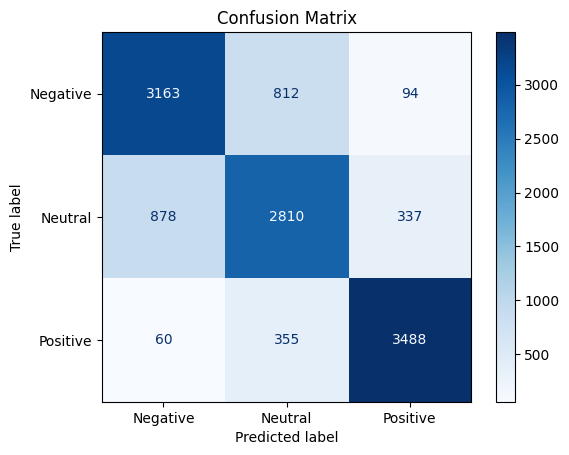

In [126]:
# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred_test)

# Here, negative = 0,neutral = 1 and positive = 2 based on the encoding done previously.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

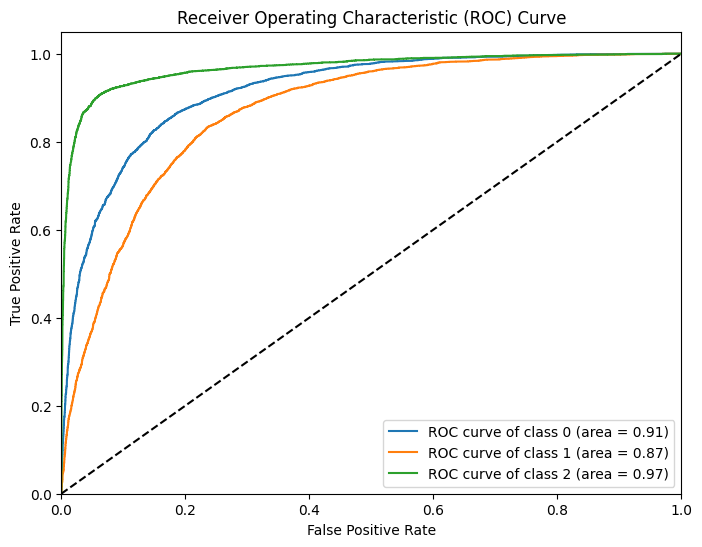

In [127]:
y_probs = lr_classifier.best_estimator_.predict_proba(X_test)

# Here, we are calculating ROC curve and AUC for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Naive Bayes Classifier

### Pseudocode 

1. IMPORT necessary libraries:
   - Pipeline, TfidfVectorizer, MultinomialNB
   - RandomizedSearchCV for hyperparameter tuning
   - classification_report, confusion_matrix, roc_curve, auc for evaluation metrics
   - matplotlib for plotting

2. CREATE a pipeline:
   - Step 1: Use TfidfVectorizer() to convert text data into TF-IDF features.
   - Step 2: Use MultinomialNB() as the classifier.

3. DEFINE the hyperparameter space:
   - TfidfVectorizer hyperparameters: max_df, min_df, ngram_range, use_idf, etc.
   - MultinomialNB hyperparameters: alpha (smoothing factor), fit_prior (True/False).

4. INITIALIZE RandomizedSearchCV:
   - Pass the pipeline and hyperparameter space.
   - Set n_iter (e.g., 20) to define the number of hyperparameter combinations to try.
   - Set cross-validation = 5 and scoring = 'accuracy' or 'f1'.
   - Set random_state for reproducibility.

5. FIT RandomizedSearchCV on the training data (X_train_val, y_train_val).

6. PRINT the best hyperparameters found.

7. PREDICT class labels for:
   - Training data (y_pred_train).
   - Test data (y_pred_test).

8. GENERATE classification report:
   - Use `classification_report()` for both training and test data.

9. CALCULATE the confusion matrix using `confusion_matrix()`.

10. DISPLAY the confusion matrix using `ConfusionMatrixDisplay()`.

11. CALCULATE predicted probabilities on the test set using `predict_proba()`.

12. FOR each class (Negative, Neutral, Positive):
    - CALCULATE False Positive Rate (fpr) and True Positive Rate (tpr) using `roc_curve()`.
    - COMPUTE Area Under Curve (AUC) using `auc()`.

13. PLOT the ROC curve for each class:
    - Use `matplotlib` to plot.
    - ADD labels and legends.
    - DISPLAY the plot.

14. END program.


In [128]:
# Here, we are generating a pipeline for developing Naive Bayes Classifier.
pipe = Pipeline([('tfidf', TfidfVectorizer()) ,                                           
                 ('classifier', MultinomialNB())])

param_dist = {
    'tfidf__max_df': np.linspace(0.7, 1.0, 10),
    'tfidf__min_df': np.arange(1, 10),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': [True, False],       
    'tfidf__smooth_idf': [True, False],                 
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': ['l1', 'l2', None], 
    'classifier__alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'classifier__fit_prior': [True, False],
}

nb_classifier = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=20, cv=5, scoring='neg_mean_squared_error',
                                   verbose=1, random_state=2024)

nb_classifier.fit(X_train_val, y_train_val)
print("Best hyperparameters: ", nb_classifier.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'tfidf__use_idf': False, 'tfidf__sublinear_tf': True, 'tfidf__smooth_idf': True, 'tfidf__norm': 'l2', 'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 3, 'tfidf__max_df': 0.7666666666666666, 'classifier__fit_prior': False, 'classifier__alpha': 0.01}


In [129]:
# Classification Report on Train and Test sets.
y_pred_train = nb_classifier.best_estimator_.predict(X_train_val)
print("Classification report for train data. \n", classification_report(y_train_val, y_pred_train))

y_pred_test = nb_classifier.best_estimator_.predict(X_test)
print("Classification report for test data. \n", classification_report(y_test, y_pred_test))

Classification report for train data. 
               precision    recall  f1-score   support

           0       0.92      0.92      0.92     35922
           1       0.87      0.91      0.89     35969
           2       0.97      0.93      0.95     36079

    accuracy                           0.92    107970
   macro avg       0.92      0.92      0.92    107970
weighted avg       0.92      0.92      0.92    107970

Classification report for test data. 
               precision    recall  f1-score   support

           0       0.77      0.74      0.75      4069
           1       0.66      0.75      0.70      4025
           2       0.92      0.83      0.87      3903

    accuracy                           0.77     11997
   macro avg       0.78      0.77      0.77     11997
weighted avg       0.78      0.77      0.77     11997



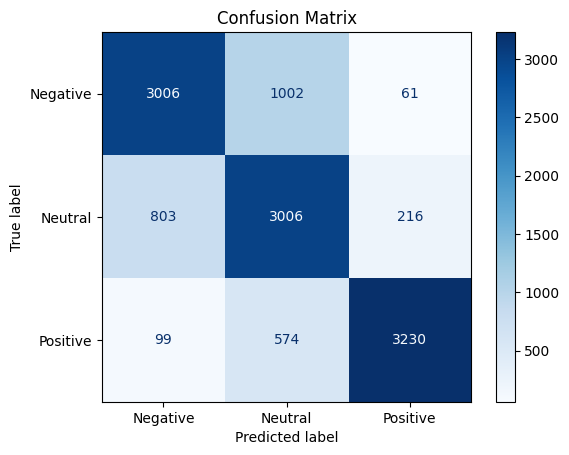

In [130]:
# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred_test)

# Here, negative = 0,neutral = 1 and positive = 2 based on the encoding done previously.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

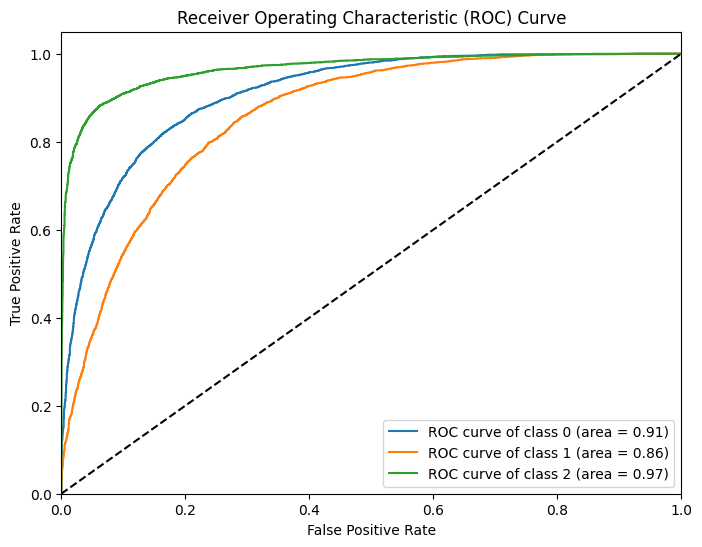

In [131]:
y_probs = nb_classifier.best_estimator_.predict_proba(X_test)

# Here, we are calculating ROC curve and AUC for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Ensemble Methods - Random Forest Classifier

### Pseudocode

1. IMPORT necessary libraries:
   - Pipeline, TfidfVectorizer, RandomForestClassifier
   - RandomizedSearchCV for hyperparameter tuning
   - classification_report, confusion_matrix, roc_curve, auc for evaluation metrics
   - matplotlib for plotting

2. CREATE a pipeline:
   - Step 1: Use TfidfVectorizer() to convert text data into TF-IDF features.
   - Step 2: Use RandomForestClassifier() as the classifier.

3. DEFINE the hyperparameter space:
   - TfidfVectorizer hyperparameters: max_df, min_df, ngram_range, use_idf, etc.
   - RandomForestClassifier hyperparameters: n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features.

4. INITIALIZE RandomizedSearchCV:
   - Pass the pipeline and hyperparameter space.
   - Set n_iter (e.g., 10) to define the number of hyperparameter combinations to try.
   - Set cross-validation = 5 and scoring = 'accuracy' or 'f1_weighted'.
   - Set random_state for reproducibility.

5. FIT RandomizedSearchCV on the training data (X_train_val, y_train_val).

6. PRINT the best hyperparameters found.

7. PREDICT class labels for:
   - Training data (y_pred_train).
   - Test data (y_pred_test).

8. GENERATE classification report:
   - Use `classification_report()` for both training and test data.

9. CALCULATE the confusion matrix using `confusion_matrix()`.

10. DISPLAY the confusion matrix using `ConfusionMatrixDisplay()`.

11. CALCULATE predicted probabilities on the test set using `predict_proba()`.

12. FOR each class (Negative, Neutral, Positive):
    - CALCULATE False Positive Rate (fpr) and True Positive Rate (tpr) using `roc_curve()`.
    - COMPUTE Area Under Curve (AUC) using `auc()`.

13. PLOT the ROC curve for each class:
    - Use `matplotlib` to plot.
    - ADD labels and legends.
    - DISPLAY the plot.

14. END program.


In [132]:
# Here, we are generating a pipeline for developing Random Forest Classifier.
pipe = Pipeline([('tfidf', TfidfVectorizer()) ,                                           
                 ('classifier', RandomForestClassifier(random_state= 2024))])

param_dist = {
    'tfidf__max_df': np.linspace(0.7, 1.0, 10),
    'tfidf__min_df': np.arange(1, 10),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': ['l1', 'l2', None],
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 20, 30, 40],
    'classifier__min_samples_split': [2, 5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8],
    'classifier__max_features': ['sqrt', 'log2'],
}

rf_classifier = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', 
                                   verbose=1, random_state=42)

rf_classifier.fit(X_train_val, y_train_val)
print("Best hyperparameters: ", rf_classifier.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters:  {'tfidf__use_idf': True, 'tfidf__sublinear_tf': True, 'tfidf__smooth_idf': False, 'tfidf__norm': 'l1', 'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 8, 'tfidf__max_df': 0.7666666666666666, 'classifier__n_estimators': 50, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 6, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 30}


In [133]:
# Classification Report on Train and Test sets.
y_pred_train = rf_classifier.best_estimator_.predict(X_train_val)
print("Classification report for train data. \n", classification_report(y_train_val, y_pred_train))

y_pred_test = rf_classifier.best_estimator_.predict(X_test)
print("Classification report for test data. \n", classification_report(y_test, y_pred_test))

Classification report for train data. 
               precision    recall  f1-score   support

           0       0.78      0.70      0.74     35922
           1       0.68      0.66      0.67     35969
           2       0.73      0.83      0.78     36079

    accuracy                           0.73    107970
   macro avg       0.73      0.73      0.73    107970
weighted avg       0.73      0.73      0.73    107970

Classification report for test data. 
               precision    recall  f1-score   support

           0       0.74      0.67      0.70      4069
           1       0.64      0.63      0.63      4025
           2       0.72      0.81      0.76      3903

    accuracy                           0.70     11997
   macro avg       0.70      0.70      0.70     11997
weighted avg       0.70      0.70      0.70     11997



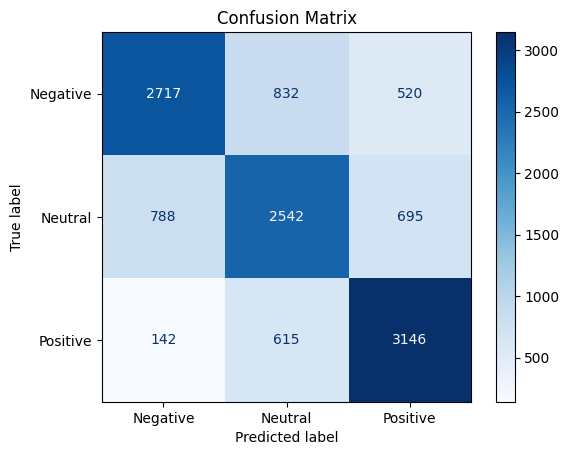

In [134]:
# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred_test)

# Here, negative = 0,neutral = 1 and positive = 2 based on the encoding done previously.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

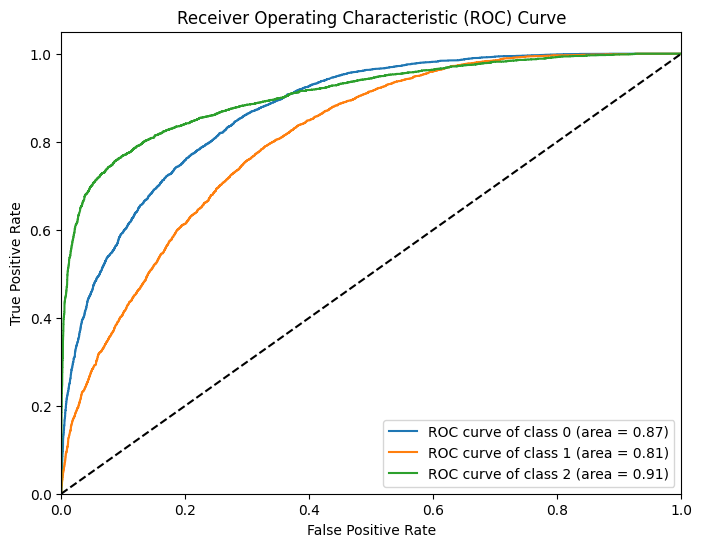

In [135]:
y_probs = rf_classifier.best_estimator_.predict_proba(X_test)

# Here, we are calculating ROC curve and AUC for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Voting Classifier

### Pseudocode

1. IMPORT necessary libraries:
   - Pipeline, TfidfVectorizer, VotingClassifier
   - LogisticRegression, MultinomialNB, RandomForestClassifier
   - RandomizedSearchCV for hyperparameter tuning
   - classification_report, confusion_matrix, roc_curve, auc for evaluation metrics
   - matplotlib for plotting

2. DEFINE best models for voting:
   - Initialize best_lr with specific hyperparameters for Logistic Regression.
   - Initialize best_nb with specific hyperparameters for Multinomial Naive Bayes.
   - Initialize best_rf with specific hyperparameters for Random Forest Classifier.

3. CREATE the pipeline:
   - Step 1: Use TfidfVectorizer() to convert text data into TF-IDF features.
   - Step 2: Use VotingClassifier() with the best models (logistic regression, naive bayes, random forest) and soft voting.

4. DEFINE hyperparameter space for TfidfVectorizer:
   - Set max_df, min_df, ngram_range, use_idf, smooth_idf, sublinear_tf, norm.

5. INITIALIZE RandomizedSearchCV:
   - Pass the pipeline and hyperparameter space.
   - Set n_iter (e.g., 7) for the number of combinations to try.
   - Set cross-validation (cv=3) and scoring (e.g., 'accuracy').
   - Set random_state for reproducibility.

6. FIT RandomizedSearchCV on training data (X_train_val, y_train_val).

7. PRINT best hyperparameters found during the search.

8. PREDICT class labels for:
   - Training data (y_pred_train).
   - Test data (y_pred_test).

9. GENERATE classification report:
   - Use classification_report() for both training and test data.

10. CALCULATE confusion matrix using confusion_matrix() for test data.

11. DISPLAY the confusion matrix using ConfusionMatrixDisplay().

12. CALCULATE predicted probabilities on the test set using predict_proba().

13. FOR each class (Negative, Neutral, Positive):
    - CALCULATE False Positive Rate (fpr) and True Positive Rate (tpr) using roc_curve().
    - COMPUTE AUC using auc().

14. PLOT the ROC curve for each class:
    - Use matplotlib to plot.
    - ADD labels and legends.
    - DISPLAY the plot.

15. END program.


In [136]:
# Here, we are generating a pipeline for developing Voting Classifier.
best_lr = LogisticRegression(C =  0.001)
best_nb = MultinomialNB(fit_prior = False, alpha = 0.01)
best_rf = RandomForestClassifier(n_estimators = 100, min_samples_split = 10, min_samples_leaf = 8, max_features = 'log2', max_depth = 40)

pipe = Pipeline([('tfidf', TfidfVectorizer()) , 
                 ('classifier', VotingClassifier(estimators=[('lr', best_lr), ('nb', best_nb), 
                ('rf', best_rf)], voting = 'soft'))])

param_dist = {
    'tfidf__max_df': np.linspace(0.7, 1.0, 10),
    'tfidf__min_df': np.arange(1, 10),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': [True, False],
    'tfidf__smooth_idf': [True, False],
    'tfidf__sublinear_tf': [True, False],
    'tfidf__norm': ['l1', 'l2', None]}

voting_classifier = RandomizedSearchCV(pipe, param_distributions=param_dist,
                                   n_iter=7, cv=3, scoring='neg_mean_squared_error',
                                   verbose=1, random_state=2024)

voting_classifier.fit(X_train_val, y_train_val)

print("Best hyperparameters: ", voting_classifier.best_params_)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dhruv/Desktop/Dhruv /DAIICT/Semester I/605_Fundamentals of ML/Classification Project/spacy_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

Best hyperparameters:  {'tfidf__use_idf': True, 'tfidf__sublinear_tf': False, 'tfidf__smooth_idf': True, 'tfidf__norm': 'l1', 'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 5, 'tfidf__max_df': 0.8666666666666667}


In [137]:
# Classification Report on Train and Test sets.
y_pred_train = voting_classifier.best_estimator_.predict(X_train_val)
print("Classification report for train data. \n", classification_report(y_train_val, y_pred_train))

y_pred_test = voting_classifier.best_estimator_.predict(X_test)
print("Classification report for test data. \n", classification_report(y_test, y_pred_test))

Classification report for train data. 
               precision    recall  f1-score   support

           0       0.88      0.87      0.88     35922
           1       0.79      0.88      0.83     35969
           2       0.96      0.87      0.92     36079

    accuracy                           0.87    107970
   macro avg       0.88      0.87      0.88    107970
weighted avg       0.88      0.87      0.88    107970

Classification report for test data. 
               precision    recall  f1-score   support

           0       0.77      0.74      0.75      4069
           1       0.65      0.76      0.70      4025
           2       0.93      0.80      0.86      3903

    accuracy                           0.77     11997
   macro avg       0.78      0.77      0.77     11997
weighted avg       0.78      0.77      0.77     11997



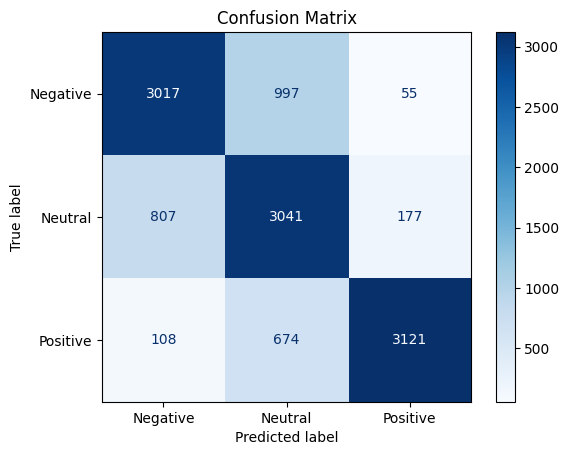

In [138]:
# Confusion Matrix.
cm = confusion_matrix(y_test, y_pred_test)

# Here, negative = 0,neutral = 1 and positive = 2 based on the encoding done previously.
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

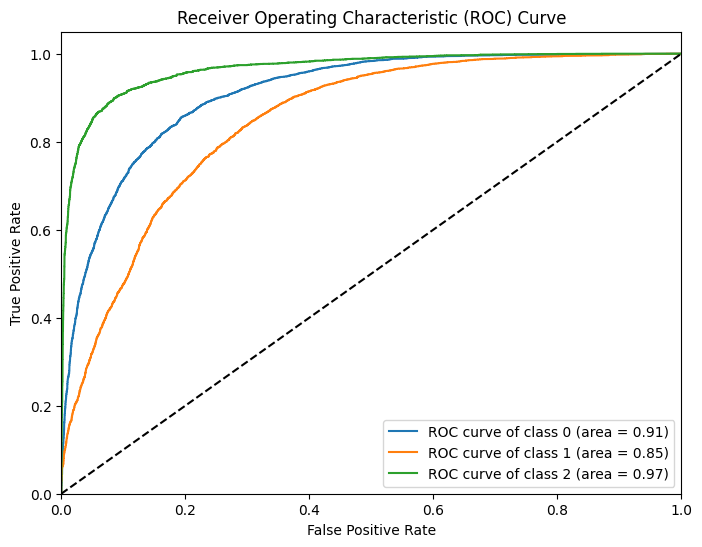

In [139]:
y_probs = voting_classifier.best_estimator_.predict_proba(X_test)

# Here, we are calculating ROC curve and AUC for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()